<a href="https://colab.research.google.com/github/utkarshpandey6/Project-Report-1-/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, gc
import torchvision
import numpy
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import tarfile
import os
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor


In [ ]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.attn_1 = Self_Attn(64, 'relu')
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.attn_2 = Self_Attn(128, 'relu')
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.attn_3 = Self_Attn(256, 'relu')
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.attn_4 = Self_Attn(512, 'relu')
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112
       
        x = self.layer1(x)          # 56x56
        x = self.attn_1(x)                      
        x = self.layer2(x)          # 28x28
        x = self.attn_2(x) 
        x = self.layer3(x)          # 14x14
        x = self.attn_3(x)
        x = self.layer4(x)          # 7x7
        x = self.attn_4(x)

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

In [ ]:
def ResNet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

In [ ]:
dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
download_url(dataset_url, '.')

  0%|          | 0/180566744 [00:00<?, ?it/s]

In [ ]:
with tarfile.open('./lfw.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')


In [ ]:
def show_example(img, label, classes):
    print('Label: ', classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
import glob
from PIL import Image

def get_mean_std(dl):
  sum, sq_sum, num_batched = 0, 0, 0
  for data, _ in dl:
    sum += torch.mean(data, dim=[0,2,3])
    sq_sum += torch.mean(data**2, dim=[0,2,3])
    num_batched += 1

  mean = sum / num_batched
  std = (sq_sum / num_batched - mean**2)**0.5
    

  return mean, std


def generate_dataset():
  data_dir = './data/lfw'
  folders = os.listdir(data_dir)
  counts = []
  train_dataset = []
  test_dataset = []
  validation_dataset = []

  # extrating classes who have more than 10 images
  for folder in folders:
    num = len(os.listdir(data_dir +"/"+folder))
    if num < 10:
      continue
    counts.append({"count": len(os.listdir(data_dir +"/"+folder)), "name":folder })


  counts = sorted(counts, key = lambda i: (i['count'], i['name']))
  counts.reverse()


  # taking top 10 folder for having total 10 classes
  counts = counts[0:10]
  counts.reverse()

  # Spliting the data and converting jpg to Tensor
  classes = []
  temp_train_dataset = []
  temp_test_dataset = []
  temp_validation_dataset = []
  for x in counts:
    folder = x["name"]
    num = len(os.listdir(data_dir +"/"+folder))
    image_tensor = []
    images=glob.glob(data_dir + "/" + folder + "/*jpg")
    classes.append(folder)
    for i in range(len(images)):
      image = images[i]
      img = Image.open(image)
      transform_train = transforms.Compose([                        
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
      ])
      transform_test = transforms.Compose([ 
        transforms.Resize((224,244)),                       
        transforms.ToTensor(),
      ])
      image_tensor = transform_test(img)
      image_tensor_train = transform_train(img)
      if i < 37:
        temp_train_dataset.append([image_tensor_train, len(classes) - 1])
      elif i >= 37 and i < 45:
        temp_validation_dataset.append([image_tensor, len(classes) - 1])
      elif i >= 45 and i < 50:
        temp_test_dataset.append((image_tensor, len(classes) - 1))

  # For verificaion purpose

  # error = []
  # for classe in classes:
  #   count = 0
  #   for x in validation_dataset:
  #     if classe == x[1]:
  #       count+=1
      
  #     if x[0].size(0) != 3 and x[0].size(1) != 224 and x[0].size(3) != 224:
  #       print(x)
  #   if count != 8:
  #     error.append({"class" :classe, "num": count})
    
  # print(error)

  
  
  # Normalizing The Data
  dataloader = DataLoader(temp_train_dataset, 5)
  mean, std = get_mean_std(dataloader)
  normalize = transforms.Normalize(mean, std)

  for i in range(len(temp_train_dataset)):
    image = temp_train_dataset[i][0]
    label = temp_train_dataset[i][1]
    image = normalize(image) 
    train_dataset.append((image, label))

  dataloader = DataLoader(temp_test_dataset, 5)
  mean, std = get_mean_std(dataloader)
  normalize = transforms.Normalize(mean, std)

  for i in range(len(temp_test_dataset)):
    image = temp_test_dataset[i][0]
    label = temp_test_dataset[i][1]
    image = normalize(image) 
    test_dataset.append((image,label))

  dataloader = DataLoader(temp_validation_dataset, 5)
  mean, std = get_mean_std(dataloader)
  normalize = transforms.Normalize(mean, std)

  for i in range(len(temp_validation_dataset)):
    image = temp_validation_dataset[i][0]
    label = temp_validation_dataset[i][1]
    image = normalize(image) 
    validation_dataset.append((image, label))


  #For verificaion purpose

  # error = []
  # for classe in classes:
  #   count = 0
  #   for x in validation_dataset:
  #     if classe == x[1]:
  #       count+=1
      
  #     if x[0].size(0) != 3 and x[0].size(1) != 224 and x[0].size(3) != 224:
  #       print(x)
  #   if count != 8:
  #     error.append({"class" :classe, "num": count})

  # if len(error):  
  #   print(error)
  # else:
  #   print("No error")

  return (train_dataset, validation_dataset, test_dataset, classes)
      

       

In [ ]:
train_set, val_set, test_set, classes = generate_dataset()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  John_Ashcroft (0)


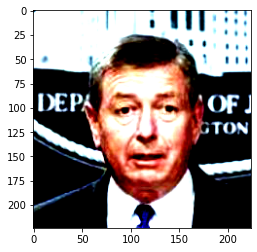

In [ ]:
show_example(train_set[0][0], train_set[0][1], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  John_Ashcroft (0)


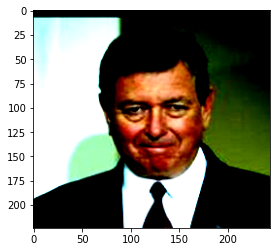

In [ ]:
show_example(test_set[0][0], train_set[0][1], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  John_Ashcroft (0)


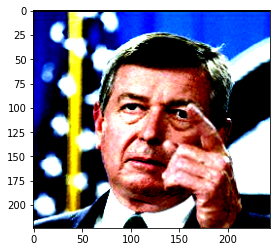

In [ ]:
show_example(val_set[0][0], val_set[0][1], classes )

In [ ]:
def split(dataset, split=0.2):
  random_seed = 42
  torch.manual_seed(random_seed);
  val_set_len = int(len(dataset) * (split))
  train_set_len = int(len(dataset) - val_set_len)
  return random_split(dataset, [train_set_len, val_set_len])

In [ ]:
train_batch_size=5
test_batch_size=5
train_dl = DataLoader(train_set, train_batch_size, shuffle=True, num_workers=2, )
val_dl = DataLoader(val_set, test_batch_size*2, num_workers=2)

In [ ]:
def get_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  return torch.device("cpu")

def to_device(data, device):
  
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DataLoaderWrapper():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)


  def __len__(self):
    return len(self.dl)

In [ ]:
train_loader = DataLoaderWrapper(train_dl,get_device())
val_loader = DataLoaderWrapper(val_dl,get_device())

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [ ]:
model = ResNet34().to('cuda')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
@torch.no_grad()
def evaluate(val_loader, model):
  val_losses = []
  acc_losses = []
  model.eval()
  for images, labels in val_loader:
     
      output = model(images)
      loss = F.cross_entropy(output, labels)
      acc = accuracy(output, labels)

      val_losses.append(loss)
      acc_losses.append(acc)
      
      

  epoch_loss = torch.stack(val_losses).mean()
  epoch_acc = torch.stack(acc_losses).mean()  
  
  return epoch_loss, epoch_acc

In [ ]:
def fit(model, epoches, lr, train_loader, val_loader, opt=torch.optim.SGD):
  optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-4 )
  
  
  history = []


  for epoch in range(epoches):
    
    
    for images, labels in train_loader:
      model.train()
      output = model(images)
      
      loss = F.cross_entropy(output, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    epoch_loss, epoch_acc = evaluate(val_loader,model)
    print("Epoch [{}], epoch_loss: {:.4f}, epoch_acc: {:.4f}".format(epoch, epoch_loss, epoch_acc))
    history.append({'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}) 


  return history

In [ ]:

for images,labels in train_loader:
  output = model(images)
  print(output.shape)
  print(labels.shape)
  loss = F.cross_entropy(output, labels)
  loss.backward()
  break

torch.Size([5, 10])
torch.Size([5])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:

history = fit(model, 300, 0.001, train_loader, val_loader)

Epoch [0], epoch_loss: 4.2955, epoch_acc: 0.1000
Epoch [1], epoch_loss: 3.7385, epoch_acc: 0.1875
Epoch [2], epoch_loss: 2.1141, epoch_acc: 0.2625
Epoch [3], epoch_loss: 2.2336, epoch_acc: 0.2250
Epoch [4], epoch_loss: 2.2324, epoch_acc: 0.3125
Epoch [5], epoch_loss: 2.6959, epoch_acc: 0.2625
Epoch [6], epoch_loss: 2.5541, epoch_acc: 0.3625
Epoch [7], epoch_loss: 2.5825, epoch_acc: 0.3500
Epoch [8], epoch_loss: 2.3370, epoch_acc: 0.3750
Epoch [9], epoch_loss: 2.4218, epoch_acc: 0.3625
Epoch [10], epoch_loss: 1.8202, epoch_acc: 0.5000
Epoch [11], epoch_loss: 1.7804, epoch_acc: 0.5125
Epoch [12], epoch_loss: 1.9864, epoch_acc: 0.4500
Epoch [13], epoch_loss: 2.5014, epoch_acc: 0.3750
Epoch [14], epoch_loss: 1.6503, epoch_acc: 0.5500
Epoch [15], epoch_loss: 2.6943, epoch_acc: 0.5125
Epoch [16], epoch_loss: 2.5573, epoch_acc: 0.5000
Epoch [17], epoch_loss: 2.1798, epoch_acc: 0.5375
Epoch [18], epoch_loss: 2.0067, epoch_acc: 0.6000
Epoch [19], epoch_loss: 2.6509, epoch_acc: 0.4500
Epoch [20]

Text(0, 0.5, 'accuracy')

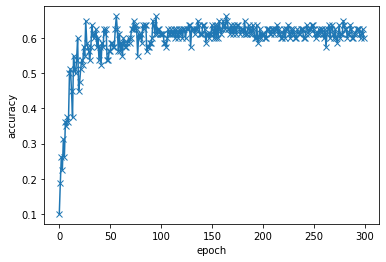

In [ ]:
overall_history = history
accuracies = [result['val_acc'] for result in overall_history] 
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
def predict_image(img, model,classes):
    xb = img.unsqueeze(0)
    yb = model(xb.cuda(non_blocking=True))
    _, preds = torch.max(yb, dim=1)
    return classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Tony_Blair (7)
Prediction = Gerhard_Schroeder


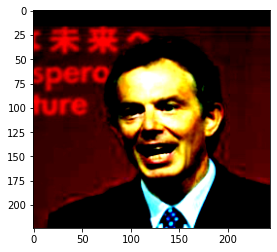

In [ ]:
image, label = test_set[36] #5041 was showing horse
show_example(image, label,classes)
print("Prediction =", predict_image(image, model,classes))

In [ ]:
torch.save(model.state_dict(), 'res_selfatten.pth')